## Executable Notebook

## Calculate k-mer abundance

We will look at ZFC4 and no protein control samples from [E-MTAB-9236](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-9236/).

> The fasta files are preprocessed and quality trimmed according to the steps in the workflow

# Data Visualisation

Populate the sample labels and load metadata. In this instance, we will analyse SALL4 ZFC4 and control SELEX libraries.

In [68]:
import pandas as pd
df = pd.read_csv("input/metadata.tsv", sep="\t", index_col=7)

_cycle0_libs = df[df["cycle"]==0]["Library"].reset_index().set_index("Library")["SampleName"].to_dict()
cycle0_libs = {}
for i, j in df["Library"].reset_index()[["Library", "SampleName"]].iterrows():
    l, s = j.values
    cycle0_libs[s] = _cycle0_libs[l]

Load the results for analysis

In [69]:
import pickle
import bz2

from collections import defaultdict
from eme_selex.sequence import canonical

k = 5

with bz2.open(f"input/results_5.pkl.bz2", "rb") as iH:
    counts = pickle.load(iH)
    _fractions = pickle.load(iH)
    models = pickle.load(iH)

# keep only canonical k-mers in the fractions container
fractions = defaultdict(dict)
fold_change = defaultdict(dict)
for _i, _j in _fractions.items():
    for _k, _l in _j.items():
        fractions[_i][canonical(_k)[0]] = _l

for _i, _j in fractions.items():
    for _k, _l in _j.items():
        if _i in cycle0_libs.keys():
            fold_change[_i][_k] = _l/fractions[cycle0_libs[_i]][_k]

# create dict for easy lookup of sample metadata
protein_dict = df["protein"].to_dict()
cycle_dict = df["cycle"].to_dict()

Transform the binary data into a data frame. To make the visualisation simpler, divide the 5-mers into groups of increasing As and Ts.

In [70]:
import numpy as np
# function to count the number of As and Ts in the k-mer
def get_at(x):
    return x.count("A") + x.count("T")

# create a pandas data frame for the fraction container
fractions_df = pd.DataFrame.from_dict(fractions)
fold_change_df = pd.DataFrame.from_dict(fold_change)
fold_change_df.index.name = "kmer"
fractions_df.index.name = "kmer"

In [71]:
def modify_cycle(x):
    zfc4_cycles = {1: 2, 2: 3, 3: 4, 4: 5, 5:6}
    none_cycles = {0: 0}
    if x.values[0] == "ZFC4":
      x.values[1] = zfc4_cycles[x.values[1]]
    elif x.values[0] == "None":
      x.values[1] = none_cycles[x.values[1]]
    return x

In [72]:
def melt_df(x):
    melt_df = pd.melt(x.reset_index(), id_vars="kmer")
    # add the information about the number of As and Ts in the k-mer
    melt_df["AT"] = melt_df["kmer"].apply(get_at)

    # add metadata
    melt_df["protein"] = melt_df["variable"].apply(lambda x: protein_dict.get(x, None))    
    melt_df["cycle"] = melt_df["variable"].apply(lambda x: cycle_dict.get(x, None))
    melt_mean = melt_df.dropna().groupby(
      ["cycle", "protein", "kmer", "AT"]).mean().reset_index()
    melt_std = melt_df.dropna().groupby(
      ["cycle", "protein", "kmer", "AT"]).std().reset_index()
    melt_mean["value_std"] = melt_std["value"]
    melt_mean[["protein_", "cycle_"]] = melt_mean[["protein", "cycle"]].apply(modify_cycle, axis=1)
    melt_mean["cycle_"] = melt_mean["cycle_"].apply(lambda x: x+np.random.uniform(low=-.25, high=.25))

    return melt_mean

In [73]:
melt_fractions_mean = melt_df(fractions_df)

In [74]:
melt_fold_change_mean = melt_df(fold_change_df)

## Visualise the enrichment of relatively GC-rich 5-mers

In [75]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

fig = px.scatter(melt_fractions_mean[melt_fractions_mean["AT"].isin([0,1,2])], 
                 facet_col="AT", x="cycle_", y="value", color="protein", 
                 error_y="value_std", template='simple_white',
                 category_orders={"protein": ["None", "ZFC4"],
                                  "AT": [0,1,2]},
                 color_discrete_sequence=["grey", "dodgerblue"],
                 width=800, height=400, custom_data=["kmer"],
                 labels={
                     "cycle_": "SELEX Cycle",
                     "value": "abundance",
                     "AT": "No. of A/T in kmer"
                 })
fig.update_traces(marker=dict(size=8, line=dict(color='DarkSlateGrey', width=1)),
                  selector=dict(mode='markers'), 
                  error_y=dict(thickness=1, width=2, color='DarkSlateGrey'),
                  hovertemplate="<br>".join([                      
                      "Abundance: %{y:.3f}",
                      "kmer: %{customdata[0]}",
                  ]))
fig.for_each_xaxis(lambda xaxis: xaxis.update(dict(
                      tickmode = 'array',
                      tickvals = [0,2.5,4.5,6.5],
                      ticktext = ['0', '1', '3', '6']
                  )))
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
    )
    #,
    #yaxis_range=[-0.05,0.65]
)
fig.show()

## Visualise the fold change (vs cycle 0) of relatively GC-rich 5-mers

In [76]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

fig = px.scatter(melt_fold_change_mean[(melt_fold_change_mean["AT"].isin([0,1,2])) & (melt_fold_change_mean["cycle"]!=0)], 
                 facet_col="AT", x="cycle_", y="value", color="protein", 
                 error_y="value_std", template='simple_white',
                 category_orders={"protein": ["None", "ZFC4"],
                                  "AT": [0,1,2]},
                 color_discrete_sequence=["grey", "dodgerblue"],
                 width=800, height=400, custom_data=["kmer"],
                 labels={
                     "cycle_": "SELEX Cycle",
                     "value": "fold change (vs cycle 0)",
                     "AT": "No. of A/T in kmer"
                 })
fig.update_traces(marker=dict(size=8, line=dict(color='DarkSlateGrey', width=1)),
                  selector=dict(mode='markers'), 
                  error_y=dict(thickness=1, width=2, color='DarkSlateGrey'),
                  hovertemplate="<br>".join([                      
                      "Fold change (vs cycle 0): %{y:.3f}",
                      "kmer: %{customdata[0]}",
                  ]))
fig.for_each_xaxis(lambda xaxis: xaxis.update(dict(
                      tickmode = 'array',
                      tickvals = [2.5,4.5,6.5],
                      ticktext = ['1', '3', '6']
                  )))
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
    )
    #,
    #yaxis=dict(range=[-5,20.5])
)
fig.show()

## Visualise the enrichment of relatively AT-rich 5-mers

In [77]:
fig = px.scatter(melt_fractions_mean[melt_fractions_mean["AT"].isin([3,4,5])], 
                 facet_col="AT", x="cycle_", y="value", color="protein", 
                 error_y="value_std", template='simple_white',
                 category_orders={"protein": ["None", "ZFC4"],
                                  "AT": [3,4,5]},
                 color_discrete_sequence=["grey", "dodgerblue"],
                 width=800, height=400, custom_data=["kmer"],
                 labels={
                     "cycle_": "SELEX Cycle",
                     "value": "abundance",
                     "AT": "No. of A/T in kmer"
                 })
fig.update_traces(marker=dict(size=8, line=dict(color='DarkSlateGrey', width=1)),
                  selector=dict(mode='markers'), 
                  error_y=dict(thickness=1, width=2, color='DarkSlateGrey'),
                  hovertemplate="<br>".join([                      
                      "Abundance: %{y:.3f}",
                      "kmer: %{customdata[0]}",
                  ]))
fig.for_each_xaxis(lambda xaxis: xaxis.update(dict(
                      tickmode = 'array',
                      tickvals = [0,2.5,4.5,6.5],
                      ticktext = ['0', '1', '3', '6']
                  )))
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
    )
    #,
    #yaxis_range=[-0.05,0.65]
)
fig.show()

## Visualise the fold change (vs cycle 0) of relatively AT-rich 5-mers

In [78]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

fig = px.scatter(melt_fold_change_mean[(melt_fold_change_mean["AT"].isin([3,4,5])) & (melt_fold_change_mean["cycle"]!=0)], 
                 facet_col="AT", x="cycle_", y="value", color="protein", 
                 error_y="value_std", template='simple_white',
                 category_orders={"protein": ["None", "ZFC4"],
                                  "AT": [3,4,5]},
                 color_discrete_sequence=["grey", "dodgerblue"],
                 width=800, height=400, custom_data=["kmer"],
                 labels={
                     "cycle_": "SELEX Cycle",
                     "value": "fold change (vs cycle 0)",
                     "AT": "No. of A/T in kmer"
                 })
fig.update_traces(marker=dict(size=8, line=dict(color='DarkSlateGrey', width=1)),
                  selector=dict(mode='markers'), 
                  error_y=dict(thickness=1, width=2, color='DarkSlateGrey'),
                  hovertemplate="<br>".join([                      
                      "Fold change (vs cycle 0): %{y:.3f}",
                      "kmer: %{customdata[0]}",
                  ]))
fig.for_each_xaxis(lambda xaxis: xaxis.update(dict(
                      tickmode = 'array',
                      tickvals = [2.5,4.5,6.5],
                      ticktext = ['1', '3', '6']
                  )))
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
    )
    #,
    #yaxis=dict(range=[-0.5,10.5])    
)
fig.show()

## Top k-mers at SELEX cycle 5

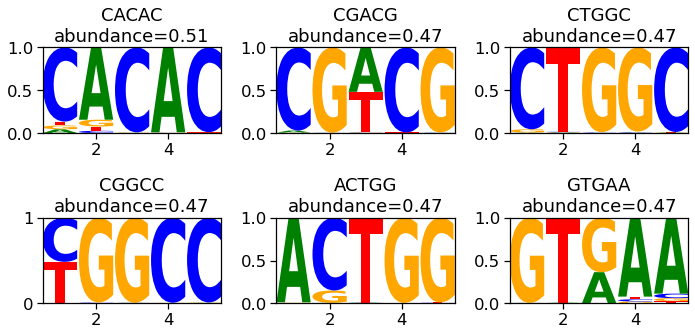

In [79]:
import pandas as pd
import logomaker
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
sns.set_context("notebook", font_scale=1.5)

import pickle

from collections import defaultdict
from eme_selex.sequence import canonical

k = 5

with bz2.open(f"input/results_5.pkl.bz2", "rb") as iH:    
    _ = pickle.load(iH)
    _ = pickle.load(iH)
    models = pickle.load(iH)

def get_logo_mean(models, samples, kmer):
    kmer_pfm = Counter()
    for s in samples:
        kmer_pfm.update(models[s][kmer])
    kmer_ppm = logomaker.transform_matrix(pd.DataFrame.from_dict(kmer_pfm).T, from_type='counts',
                             to_type="probability")
    return kmer_ppm

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for (i, j), ax in zip(melt_fractions_mean[(melt_fractions_mean["protein"]=="ZFC4") & (melt_fractions_mean["cycle"]==5)][["cycle", "protein", "kmer", "AT", "value"]].sort_values(
  by="value", ascending=False).head(6).iterrows(), axes.flatten()):
    cycle, protein, kmer, at, fraction = j.values
    samples = list(df[(df["protein"]==protein) & (df["cycle"]==cycle)].index)    
    kmer_ppm = get_logo_mean(models, samples, kmer)
    logomaker.Logo(kmer_ppm, ax=ax)
    ax.set_title(f"{kmer}\nabundance={fraction:.2f}")
_ = fig.tight_layout()